In [1]:
! pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from datasets import load_dataset

dataset = load_dataset("dair-ai/emotion")

  0%|          | 0/3 [00:00<?, ?it/s]

Brief ideas:
1. frequency by class
2. relation of text length to class
3. common words (nltk?)
4. build feature and draw t-sne
5. bi-grams, tri-grams


In [3]:
import numpy as np
import matplotlib.pyplot as plt


In [4]:
# 0 - sadness
# 1 - joy
# 2 - love
# 3 - anger
# 4 - fear
# 5 - surprise
class_names = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

In [5]:
dataset['train'][0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [6]:
n_classes = 6

In [7]:
split_names = ['train', 'validation', 'test']
char_length = {i: [] for i in range(n_classes)}
word_length = {i: [] for i in range(n_classes)}
class_counts = {name: [0] * n_classes for name in split_names}
for split in split_names:
    for item in dataset[split]:
        lbl = item['label']
        class_counts[split][lbl] += 1
        char_length[lbl].append(len(item['text']))
        word_length[lbl].append(len(item['text'].split(' ')))




### 1. Frequency by class

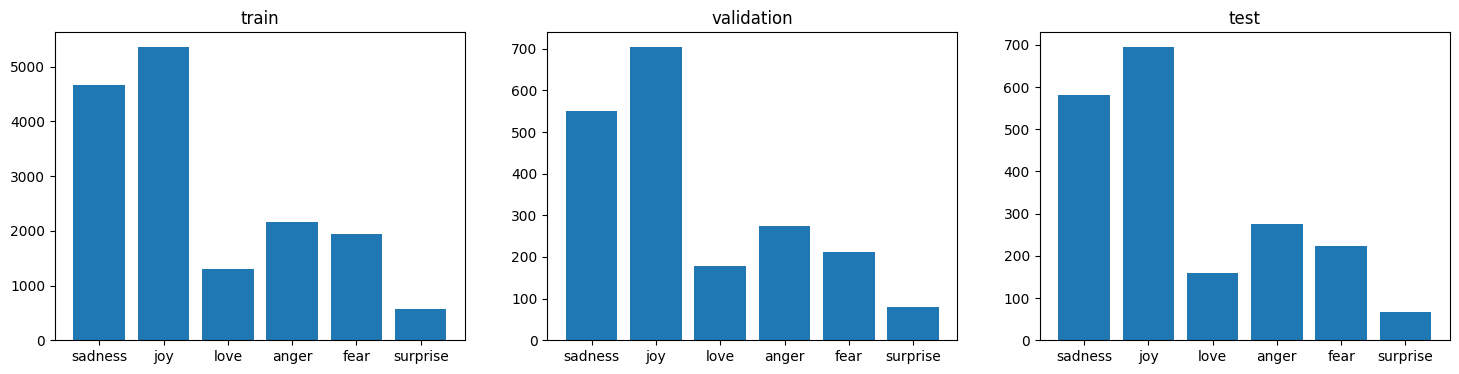

In [8]:
plt.figure(figsize=(18, 4))
for i, split in enumerate(split_names):
    plt.subplot(1, 3, i + 1)
    plt.title(split)
    plt.bar(class_names, class_counts[split])

### 2. Tweet length depending on class

<BarContainer object of 6 artists>

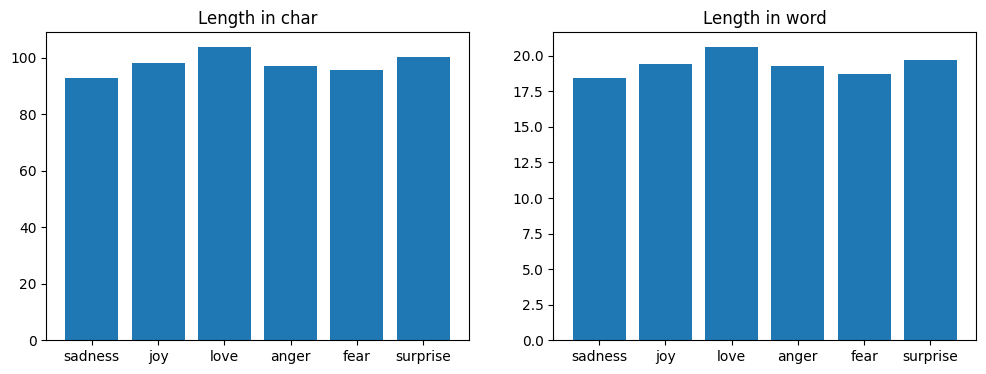

In [9]:
plt.figure(figsize=(12, 4))
mean_sizes_char = []
mean_sizes_word = []
names = []
for class_i in range(n_classes):
    mean_sizes_char.append(np.mean(char_length[class_i]))
    mean_sizes_word.append(np.mean(word_length[class_i]))

plt.subplot(121)
plt.title("Length in char")
plt.bar(class_names, mean_sizes_char)

plt.subplot(122)
plt.title("Length in word")
plt.bar(class_names, mean_sizes_word)

### 3. Most frequent words

In [10]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords 
ignore_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [12]:
def get_lemmas(text):
    words_raw = text.lower().split()
    text_lemmas = " ".join([lemmatizer.lemmatize(w.strip(".,!?:")) for w in words_raw if w not in ignore_words])
    return text_lemmas


In [13]:
corpus = []
labels = np.zeros(len(dataset['train']))
for i, item in enumerate(dataset['train']):
    corpus.append(get_lemmas(item['text']))
    labels[i] = item['label']

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
features_names = vectorizer.get_feature_names_out()

In [15]:
top_n_words = {}
n = 15
for class_i in range(n_classes):
    count_for_class = np.array(np.sum(X[labels==class_i], axis=0))[0]
    sorted_freqs_ids = np.argsort(count_for_class)[::-1]
    top_n_words[class_i] = features_names[sorted_freqs_ids[:n]]

In [16]:
for class_i in range(n_classes):
    print(class_names[class_i])
    print(list(top_n_words[class_i]))
    print('-----')

sadness
['feel', 'feeling', 'like', 'im', 'know', 'really', 'time', 'get', 'day', 'thing', 'ive', 'would', 'make', 'still', 'little']
-----
joy
['feel', 'feeling', 'like', 'im', 'time', 'make', 'really', 'get', 'know', 'day', 'want', 'one', 'people', 'would', 'life']
-----
love
['feel', 'feeling', 'like', 'im', 'love', 'really', 'know', 'time', 'want', 'one', 'sweet', 'loving', 'life', 'passionate', 'caring']
-----
anger
['feel', 'feeling', 'like', 'im', 'time', 'get', 'really', 'know', 'thing', 'little', 'want', 'people', 'even', 'way', 'make']
-----
fear
['feel', 'feeling', 'im', 'like', 'little', 'know', 'bit', 'time', 'really', 'people', 'want', 'thing', 'get', 'still', 'think']
-----
surprise
['feel', 'feeling', 'im', 'like', 'amazed', 'impressed', 'overwhelmed', 'weird', 'surprised', 'curious', 'funny', 'strange', 'shocked', 'little', 'time']
-----


### 4. N-gram features visualization

In [36]:
ngram_vectorizer = CountVectorizer(analyzer='char_wb', ngram_range=(2,2))
X_ngrams = ngram_vectorizer.fit_transform(corpus)
X_ngrams_np = X_ngrams.toarray()

In [37]:
print(len(ngram_vectorizer.get_feature_names_out()))

626


In [44]:
from sklearn.decomposition import PCA
pca = PCA(n_components=500)
X_pca = pca.fit_transform(X_ngrams_np)

In [45]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=5).fit_transform(X_pca)

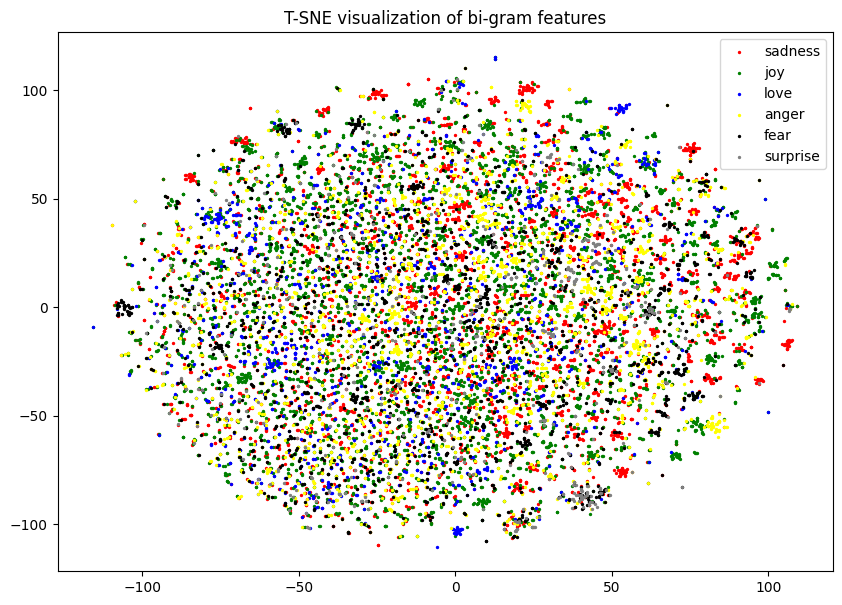

In [48]:
colors = ['red', 'green', 'blue', 'yellow', 'black', 'grey']
plt.figure(figsize=(10,7))
for class_i, c in enumerate(colors):
    data = X_embedded[labels==class_i]
    x = data[:, 0]
    y = data[:, 1]
    plt.scatter(x, y, c=c, s=2)
plt.title("T-SNE visualization of bi-gram features")
plt.legend(class_names)